# 13. 추론(Inference)

사람들이 보통 일반적 추론 방식과 베이지안 추론을 비교할 때마다 가장 자주 나오는 질문 중 하나는 'What about p-values?' 같은 것이다. 

또한 가장 일반적인 예제 중 하나는 두 집단간의 평균에 차이가 있는 지를 통해 집단을 비교하는 것이다.

고전적 통계 추론에서, 이 설정에서 사용하는 가장 일반적인 도구는 students's t-test 이고 이 결과값은 p-value 이다. 이 과정은 영가설 유의성 검정이다.

베이지안 방식에서는 두 집단 간의 차이에 대한 사후분포를 구한다. 

이 분포를 기준으로 가장 가능성 있는 차이가 어떻게 되고, 실제 차이 정도의 신뢰 구간은 어떻게 되는지, 한 집단이 가장 클 확률은 얼마인지, 차이 정도가 특정 기준을 넘어갈 확률은 얼마인지 같은 질문에 답할 수 있다.

통계 교과서에서 가져온 통제 집단과의 비교를 통해 교육적 조치의 효과를 측정하는 문제를 풀면서 이 과정을 설명해 보도록 하겠다.


## 13.1 독해 능력 향상

여기서는 1989년부터 통계 교과서에 예제로 실렸고, 데이터 관련 예제를 수집한 웹페이지인 DASL에 게시되었던, 1987년 교육 심리학 박사 학위 논문에서 사용된 데이터를 사용한다.

다음은 DASL에 서술된 내용이다.

```
한 교육자는 교실에서 새로운 지시적 읽기 활동이 초등학생의 읽기 능력의 일부 측면을 향상시키는 데 도움이 되는지를 확인하기 위해 실험을 실시했다. 

이 교육자는 21명의 3학년생을 대상으로 8주간 실험을 진행했다. 다른 3학년 23명의 통제군 교실에서는 이 활동이 없는 기존과 동일한 커리큘럼을 따랐다. 8주 후 모든 학생들이 시험을 치렀다.
```

In [4]:
import pandas as pd

df = pd.read_csv('/mnt/c/TIL/Bayes/drp_scores.csv', skiprows = 21, delimiter= '\t')
df.head(3)

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58


Treat 열에는 각 학생이 실험군인지 통제군인지 표시되어 있다. Response 열의 값은 시험 점수다.

이번에는 groupby를 사용해서 실험군과 통제군을 나눠보겠다.

In [5]:
grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    responses[name] = group['Response']

In [6]:
from empiricaldist import Pmf,Cdf
from utils import decorate

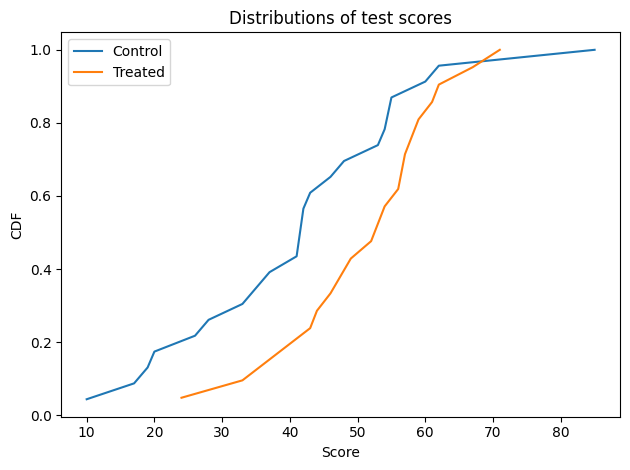

In [7]:
for name, response in responses.items():
    cdf = Cdf.from_seq(response)
    cdf.plot(label = name)

decorate(xlabel = 'Score',
         ylabel = 'CDF', 
         title = 'Distributions of test scores')

두 분포간에 겹치는 부분이 있으나, 전반적으로 실험군의 점수가 더 높아보인다. 

점수 분포는 각 그룹 모두 정확한 정규분포를 나타내지는 않으나, 정규분포 모델을 선택해도 충분히 납득할 수 있는 정도의 형태다(시그모이드 형태).

따라서 학생의 모집단에서 점수의 분포는 정규분포를 띄고, 아직 평균과 표준편차는 알 수 없다고 가정하도록 하겠다.

이 두 값을 mu와 sigma로 표기하여, 이 값을 추정하기 위해 베이지안 갱신을 사용할 것이다. 


## 13.2 매개변수 추정

앞에서 했던 것처럼 매개변수에 대한 사전분포가 필요하다. 여기에는 두 개의 매개변수를 사용하므로, 결합분포 형태가 된다. 

각 매개변수에 대한 주변분포를 선택한 후 이 둘의 외적을 구해서 결합분포를 만들도록 한다. 

mu와 sigma를 균등분포로 가정해서 간단히 시작해보자. 다음 함수는 균등분포를 나타내는 Pmf 객체를 만든다. 

In [8]:
from empiricaldist import Pmf

def make_uniform(qs, name = None, **options):
    """Make Uniform Distribution Pmf"""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

make_uniform()은 다음의 두 매개변수를 사용한다.

- qs: 값의 배열
- name: 인덱스에 들어갈 문자열. Pmf를 출력할 때 표시된다. 

다음은 mu에 대한 사전분포다. 

In [9]:
import numpy as np

qs = np.linspace(20, 80, num = 101)
prior_mu = make_uniform(qs, name = 'mean')

prior_mu

,probs
mean,
20.0,0.009901
20.6,0.009901
21.2,0.009901
21.8,0.009901
22.4,0.009901
...,...
77.6,0.009901
78.2,0.009901
78.8,0.009901


시행착오에 대한 하한선과 상한선을 정해주었다. 이 값이 사후분포에서는 어떻게 나타날지는 이후에 설명하겠다. 

다음은 sigma의 사전분포다. 

In [10]:
qs = np.linspace(5,30, num = 101)
prior_sigma = make_uniform(qs, name = 'std')

그럼 이제 결합분포를 만들 수 있다.

In [11]:
def make_joint(s1:pd.Series,s2:pd.Series):
    X,Y = np.meshgrid(s1,s2)
    return pd.DataFrame(X*Y, columns=s1.index, index=s2.index)

In [12]:
prior = make_joint(prior_mu, prior_sigma)

In [13]:
# 통제군
data = responses['Control']
data.shape

(23,)

다음 절에서는 사전분포의 각 매개변수 쌍에 대해 이 데이터로 가능도를 구해보자.

## 13.3 Likelihood

mu와 sigma의 각 가설값 쌍에 대한 데이터셋의 각 점수별 확률을 알아보자. 첫번째 축에는 mu의 값을, 두 번째 축에는 sigma의 값을, 세번째 축에는 데이터셋의 점수를 넣은 3차원 그래프를 만들어서 확인해보자.

In [14]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)

mu_mesh.shape

(101, 101, 23)

여기에 norm.pdf 를 사용해서 매개변수의 각 가설값 쌍에 대한 각 점수의 확률밀도를 구한다. 

In [15]:
from scipy.stats import norm

densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
densities.shape

(101, 101, 23)

결과값은 3차원 배열로 나타난다. 데이터 축인 axis =2 에 따라 이 밀도값을 곱해서 가능도를 구해보자.

In [16]:
likelihood = densities.prod(axis = 2)
likelihood.shape

(101, 101)

결과는 각 매개변수의 가설값 쌍에 대한 전체 데이터셋의 가능도가 들어있는 2차원 배열이다. 

이 배열을 다음과 같이 사전분포 갱신에 사용할 수 있다. 

In [17]:
from utils import normalize

posterior = prior * likelihood
normalize(posterior)
posterior.shape

(101, 101)

In [18]:
def update_norm(prior, data):
    mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    # 여기에 norm.pdf 를 사용해서 매개변수의 각 가설값 쌍에 대한 각 점수의 확률밀도를 구한다. 
    densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
    # 결과값은 3차원 배열로 나타난다. 
    # 데이터 축인 axis =2 에 따라 이 밀도값을 곱해서 가능도를 구함
    likelihood = densities.prod(axis = 2)
    # 결과는 각 매개변수의 가설값 쌍에 대한 전체 데이터셋의 가능도가 들어있는 2차원 배열
    # 이 배열을 다음과 같이 사전분포 갱신에 사용할 수 있다. 
    posterior = prior * likelihood
    normalize(posterior)
    return posterior

In [20]:
data = responses['Control']
posterior_control = update_norm(prior, data)


data = responses['Treated']
posterior_treated = update_norm(prior, data)

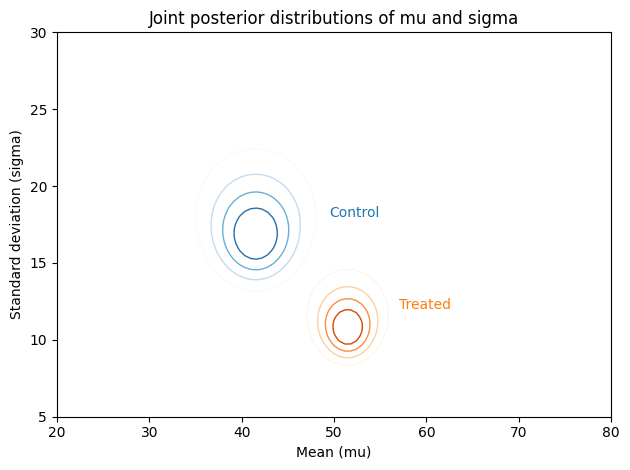

In [22]:
import matplotlib.pyplot as plt
from utils import plot_contour

plot_contour(posterior_control, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate(xlabel='Mean (mu)', 
         ylabel='Standard deviation (sigma)',
         title='Joint posterior distributions of mu and sigma')

x축을 보면 실험군의 평균 점수가 더 높다. y축을 보면 실험군의 표준편차가 더 낮다. 

이 실험이 이런 차이를 만들어냈다고 생각한다면, 실험으로 인해 평균 점수를 올리고 분포 정도를 낮췄음을 데이터가 보여주고 있다고 볼 수 있다.

mu와 sigma의 주변분포를 살펴보면 이 차이를 보다 명확히 알 수 있다.

## 13.4 사후주변분포

11.7절의 주변분포에서 살펴보았던 주변분포를 사용해서 모평균에 대한 사후주변분포를 구해보자. 


```python
def marginal(joint, axis):
    """Compute a marginal distribution.

    axis=0 returns the marginal distribution of the first variable
    axis=1 returns the marginal distribution of the second variable

    joint: DataFrame representing a joint distribution
    axis: int axis to sum along

    returns: Pmf
    """
    return Pmf(joint.sum(axis=axis))


def pmf_marginal(joint_pmf, level):
    """Compute a marginal distribution.

    joint_pmf: Pmf representing a joint distribution
    level: int, level to sum along

    returns: Pmf
    """
    return Pmf(joint_pmf.sum(level=level))

```

In [23]:
from utils import marginal

pmf_mean_control = marginal(posterior_control, 0)
pmf_mean_treated = marginal(posterior_treated, 0)

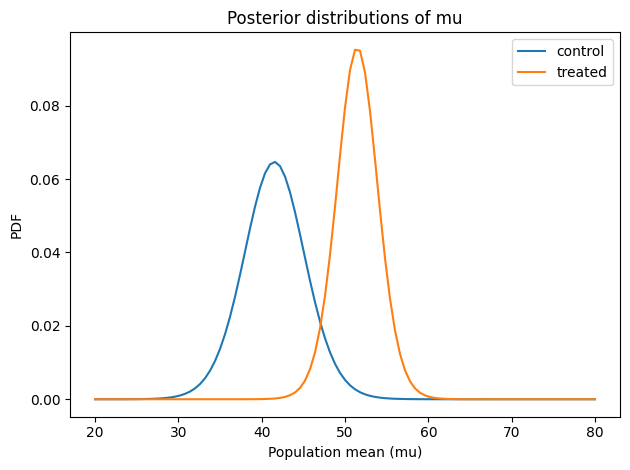

In [24]:
pmf_mean_control.plot(label = 'control')
pmf_mean_treated.plot(label = 'treated')
decorate(xlabel='Population mean (mu)', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

양쪽 모두 범위 끝쪽의 사후평균은 0에 가깝다. 이는 사전평균에서 정한 범위가 충분했음을 의미한다. 

두 집단의 주변분포를 비교해보면, 실험군의 모평균이 더 높다. prob_gt()를 사용하면 높은 정도에 대한 확률을 구할 수 있다. 

In [25]:
Pmf.prob_gt(pmf_mean_treated, pmf_mean_control)

0.980479025187326

실험군 평균이 더 높을 확률이 약 98%다. 

## 13.5 차이의 분포

집단간 차이를 수량화하기 위해 sub_dist()를 사용해서 차이의 분포를 구해보겠다. 

In [26]:
pmf_diff = Pmf.sub_dist(pmf_mean_treated, pmf_mean_control)

sub_dist() 같은 메서드를 사용할 경우 두 가지 주의점이 있다. 

하나는 결과값이 대개의 경우 원래 Pmf보다 많은 원소를 포함한다. 이 예제에서는 원래의 두 분포가 동일한 원소 개수를 가지므로 크기가 늘어난 정도는 무난하다.

In [27]:
len(pmf_mean_treated), len(pmf_mean_control), len(pmf_diff)

(101, 101, 879)

최악의 경우, 결과의 크기는 본래 데이터 크기 간의 외적(product)만큼 커질 수 있다. 

또 다른 주의할 점은 Pmf를 그릴 때, 지저분해질 수가 있다.

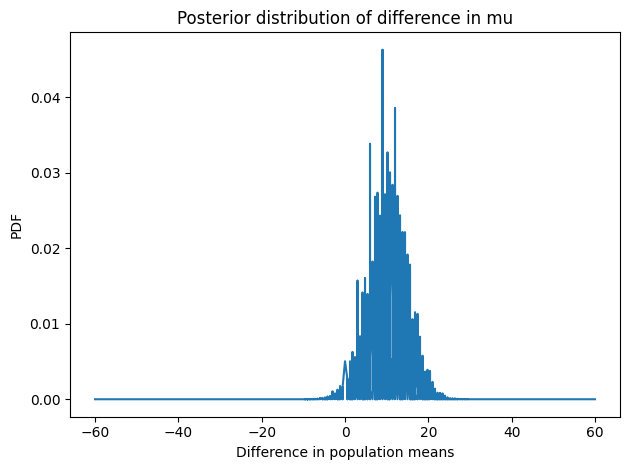

In [28]:
pmf_diff.plot()

decorate(xlabel='Difference in population means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

이런 제약조건을 극복하는 방법에는 두 가지가 있다. 하나는 noise 를 다듬어주는 cdf를 그리는 것이다.

In [29]:
cdf_diff = pmf_diff.make_cdf()

<Axes: >

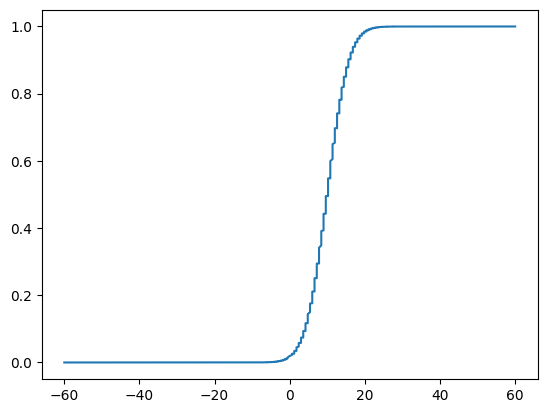

In [30]:
cdf_diff.plot()

다른 방법은 커널밀도추정을 사용해서 동일하게 나눠진 격자 상에서 PDF의 평활추정(smooth approximation)을 하는 것이다. 

In [32]:
from scipy.stats import gaussian_kde

def kde_from_pmf(pmf, n = 101):
    "Make a kernel density estimation for a Pmf"
    kde = gaussian_kde(pmf.qs, weights = pmf.ps)
    qs = np.linspace(pmf.qs.min(), pmf.qs.max(),n)
    ps = kde.evaluate(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

kde_from_pmf 는 pmf와 KDE를 구하는 데 사용되는 수를 인자로 받는다.

이 함수에서는 9.3절의 커널밀도추정에서 살표보았던 gaussian_kde 에 Pmf의 확률을 가중치로 적용한다.

이렇게 하면 Pmf 내의 확률이 높아지면 추정 밀도 값도 높아진다. 집단간 차이의 Pmf에 대한 커널 밀도 추정은 다음과 같다. 

In [33]:
kde_diff = kde_from_pmf(pmf_diff)

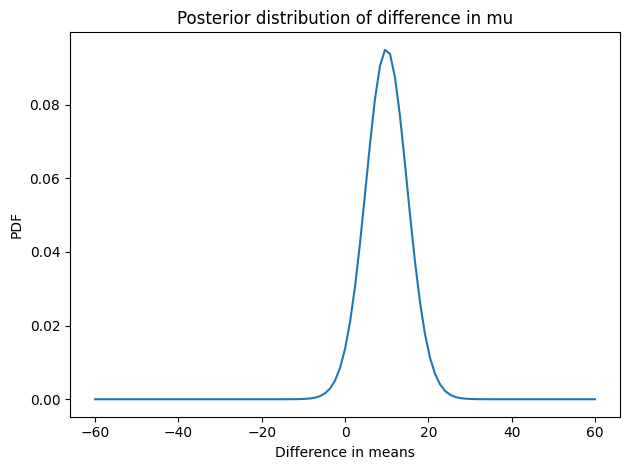

In [34]:
kde_diff.plot()

decorate(xlabel='Difference in means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

그래프를 보면 이 실험은 2점에서 17점 정도 올리는 효과가 있었던 것으로 보인다.

## 13.6 요약통계 사용하기

이 예제에서 사용한 데이터는 크지 않으므로 모든 가설 하에서 모든 점수의 확률을 구하는 데 그다지 많은 시간이 걸리지 않는다.

하지만 이 결과가 3차원 배열이라는 것을 생각해보면, 더 큰 데이터셋에서는 실제로 계산하는 데 오래 걸릴 수 있다. 

또한 더 큰 데이터셋을 사용하는 경우 가능도는 매우 작아져서 부동 소수점 연산을 사용해서 구하기 어려울 수도 있다. 

그래서 특정 데이터셋에서의 확률을 구하는 것이다. 가능한 데이터셋은 무수히 많고, 그 중 하나의 확률은 매우 낮다. 

이런 현상의 대안으로 데이터셋의 요약값을 구하고 그 요약값의 가능도를 구하는 방법이 있다. 

예를 들어, 어느 데이터의 평균과 표준편차를 구하면 각 가설 하에서 이 요약통계값의 가능도를 구할 수 있다. 

어느 집단의 모평균이 42고 모표준편차가 17이라고 해보자.

In [35]:
mu = 42; sigma = 17

이 모집단에서 임의로 크기 n = 20 인 표본을 추출했다고 하자. 이 표본의 평균을 m, 표준편차를 s라고 하자. 

그리고 표본에 대한 각 값은 다음과 같았다. 

In [36]:
n = 20
m = 41
s = 18

요약통계값 m과 s는 모수와 큰 차이가 나지 않으므로, 그다지 불가능한 값은 아니다.

likelihood 를 계산하기 위해 수리통계의 다음 세 가지 결론을 이용하면 좋다:

- $\mu$ 와 $\sigma$가 주어진 경우, m의 분포는 $\mu$ 와 $\frac{\sigma}{\sqrt{n}}$ 을 매개변수로 사용하는 정규분포를 따른다. 
- s의 분포는 더 복잡하지만, $ t = \frac{ns^{2}}{\sigma^{2}}$ 으로 변환하면, t의 분포는 매개변수 n - 1 을 사용하는 카이제곱분포를 따른다.
- 바수의 정리에 따르면, m과 s는 독립적이다. 

그럼 mu와 sigma를 사용해서 주어진 m과 s의 가능도를 구하자.

우선 m의 분포를 나타내는 norm 객체를 만들 것이다. 

In [37]:
dist_m = norm(mu, sigma/np.sqrt(n))

이 변수는 표본평균의 분포다. 우리는 이를 사용해서 m이 41일 때 이 관측값의 가능도를 구할 수 있다.

In [38]:
like1 = dist_m.pdf(m)
like1

0.10137915138497372

이번에는 s가 41때의 이 값의 가능도를 구해보자. 일단 변환할 대상인 t를 만들자. 

In [39]:
t = n * s ** 2 / sigma ** 2
t

22.422145328719722

그 후 t가 따르는 분포인 자유도 n-1 의 카이제곱분포의 객체, chi2 라는 객체를 만든다.

In [40]:
from scipy.stats import chi2

dist_s = chi2(n-1)

그럼 t의 가능도를 구할 수 있다. 

like2 = dist_s.pdf(t)
like2

마지막으로 m과 s가 서로 독립이므로 둘의 joint likelihood 는 가능도간의 곱(product)으로 나타낼 수 있다. 

이에 대해서는 다음 절에서 갱신을 다루면서 살펴보자. 


## 13.7 요약통계 갱신

이제 갱신을 할 수 있는 모든 준비를 마쳤다. 우선 다음 두 군집에 대해 요약통계를 구하자.

In [41]:
summary = {}

for name, response in responses.items():
    summary[name] = len(response), response.mean(), response.std()

summary

{'Control': (23, 41.52173913043478, 17.148733229699484),
 'Treated': (21, 51.476190476190474, 11.00735684721381)}

결과는 각 군집별 이름에 표본 크기 n, 표본 평균 m, 표본 표준편차 s를 기록한 튜플을 연결한 dictionary 자료다. 

control 군의 요약통계를 갱신하는 과정을 살펴보자.

In [42]:
n, m, s = summary['Control']

x축에는 mu의 가설값을 넣고 y축에는 sigma의 가설값을 넣은 메쉬그리드를 만들자. 

In [43]:
prior

mean,20.0,20.6,21.2,21.8,22.4,23.0,23.6,24.2,24.8,25.4,...,74.6,75.2,75.8,76.4,77.0,77.6,78.2,78.8,79.4,80.0
std,,,,,,,,,,,,,,,,,,,,,
5.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.25,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.50,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.75,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
6.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
29.25,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
29.50,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098


In [44]:
mus, sigmas = np.meshgrid(prior.columns, prior.index)
mus.shape

(101, 101)

이제 각 매개변수의 쌍으로부터 표본평균이 m이 될 가능도를 구할 수 있다. 

표본표준편차가 s될 가능도 역시 구할 수 있다.

In [45]:
like1 = norm(mus, sigmas/np.sqrt(n)).pdf(m)
like1

array([[1.12138768e-093, 1.37168712e-088, 1.20480291e-083, ...,
        9.14305172e-279, 8.96259722e-288, 6.30867639e-297],
       [4.27968922e-085, 1.76166794e-080, 5.36995022e-076, ...,
        5.63037483e-253, 3.79681624e-261, 1.89599087e-269],
       [1.16900870e-077, 1.87224466e-073, 2.28051432e-069, ...,
        1.26467585e-230, 4.53740877e-238, 1.23811770e-245],
       ...,
       [1.42468939e-004, 1.99466837e-004, 2.76623526e-004, ...,
        6.86449049e-010, 3.78279853e-010, 2.06483816e-010],
       [1.56510574e-004, 2.17895472e-004, 3.00531350e-004, ...,
        9.25591915e-010, 5.15176066e-010, 2.84072283e-010],
       [1.71510329e-004, 2.37470520e-004, 3.25786901e-004, ...,
        1.23862113e-009, 6.96142268e-010, 3.87669839e-010]])

In [46]:
ts = n * s**2 / sigmas ** 2
like2 = chi2(n-1).pdf(ts)
like2.shape

(101, 101)

마지막으로 두 가능도를 모두 갱신한다. 

In [47]:
posterior_control2 = prior * like1 * like2 # 사후확률 = 사전확률 * mu 일 우도 * sigma 일 우도
normalize(posterior_control2)

0.00030965351017402847

앞의 과정을 요약하면 아래 함수가 된다.

In [48]:
def update_norm_summary(prior, data):
    n,m,s = data
    mu_mesh, sigma_mesh = np.meshgrid(prior.columns, prior.index) # mean, std의 가능한 모든 조합
    like1 = norm(mu_mesh, sigma_mesh/np.sqrt(s)).pdf(m) # mu_mesh, sigma_mesh를 따르는 정규분포에서 m 이 나올 likelihood
    like2 = chi2(n-1).pdf(n * s **2 / sigma_mesh **2)
    posterior = prior * like1 * like2
    normalize(posterior) # normalize = utils.normalize()
    return posterior

다음과 같이 실험군에 대한 값을 갱신할 수 있다. 

In [50]:
summary

{'Control': (23, 41.52173913043478, 17.148733229699484),
 'Treated': (21, 51.476190476190474, 11.00735684721381)}

In [49]:
data = summary['Treated']
posterior_treated2 = update_norm_summary(prior, data)

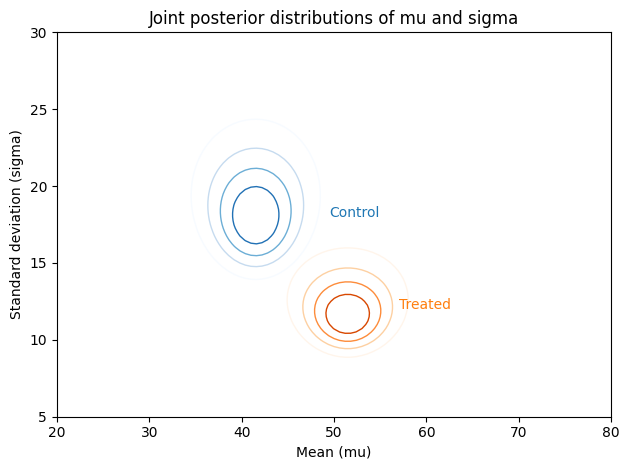

In [51]:
plot_contour(posterior_control2, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated2, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate(xlabel='Mean (mu)', 
         ylabel='Standard deviation (sigma)',
         title='Joint posterior distributions of mu and sigma')

## 13.8 주변분포 비교

앞서 구한 값을 기반으로 다시 사후주변분포를 구해보자.

In [52]:
from utils import marginal

pmf_mean_control2 = marginal(posterior_control2, 0)
pmf_mean_treated2 = marginal(posterior_treated2, 0)

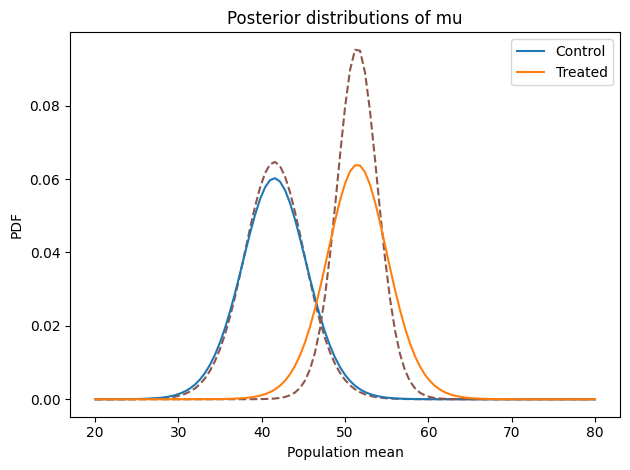

In [53]:
pmf_mean_control.plot(color='C5', ls='--')
pmf_mean_control2.plot(label='Control')
pmf_mean_treated.plot(color='C5', ls='--')
pmf_mean_treated2.plot(label='Treated')

decorate(xlabel='Population mean', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

기존의 전체 데이터셋을 사용해 구했던 사후분포와 유사하지만, 점선으로 표시되는 기존의 분포와 다르게 양 옆으로 좀 더 퍼진 형태를 보인다. 

이는 데이터의 분포가 정규분포를 따른다고 가정하고 요약통계량을 사용해서 갱신했기 때문이다. 
이는 불완전한 가정을 통해 시작했기 때문에, 요약통계량을 사용하는 경우 이처럼 데이터의 실제 분포에 따른 일부 정보를 잃어버릴 수 있다. 정보가 적어지면 매개변수에 대한 확실성이 낮아질 수밖에 없다. 

## 13.9 요약

이 장에서는 결합분포를 사용해서 두 개의 매개변수인 mu와 sigma의 사전확률을 나타냈다. 

그리고 이 분포를 두 가지 방법을 사용해서 갱신했다. 

1. 전체 데이터셋과 PDF를 사용한 갱신
2. 요약통계량을 사용한 갱신

요약통계량을 사용하면 더 효율적으로 계산할 수 있지만, 과정 중에 일부 정보를 잃을 수 있다.

많은 도메인에서 정규분포가 나타나므로, 이 장에서 사용한 방법은 널리 응용할 수 있다.